UNIVARIATE TIME SERIES ANALYSIS:

Predicting the price of bitcoin using ARIMA and Neural Net Recurssion techniques

By Joe Ganser

Abstract:

The purpose of this study was to investigate and compare the effectivity of the ARIMA modelling technique to the Neural Net Recurssion for forecasting the value of a time series. The example used here were the closing prices of bitcoin from the date range between August 20th 2010 to August 28th, 2017. The data set consisted of closing prices bitcoin every other day, and there were a total of 1283 data points to be modelled.
Note: this notebook was written in Python 2.7

The study consists of two parts - the first part was forecasting with ARIMA, the second with Neural nets.
The metric of accuracy were the root mean square error, and the final forecast was across the last two weeks (the last 7 entries) of the time series. Specifically, I was trying to predict the price between the dates of August 13th to August 27th, 2017. The data was obtained from kaggle, and the prices are accurate relative to public knowledge. 

The data can be found here: https://www.kaggle.com/mczielinski/bitcoin-historical-data

There was a similarity of structure in both models despite a different technique. Specifically, the signal needed to be separated from the noise to find the general structure. This means that the series values had to be transformed so that it is "stationary" meaning it satisfies the Dickey Fuller Test in stochastic caclulus.
https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test

In conjunction, both models were placed in a for loop over the last 7 points in the data set. Specifically,
the model was made based upon all the dates made upto the 7th day before the end, and a forecast for one day out was made for the 6th day before the end. Then again, a model was made based on all the dates upto the 6th date before the end of the series, and the model was used to forecast the price for the 5th day before the end of the series. This continued until the end of the time series.

The models were shown to be very close in accuracy, as can be seen here:
<img src="August2017_both_models.png"> 

Introduction: 

-loading the data 

-defining the dickey fuller test

-formatting the data so it is stationary (signal is separated from the noise).

The data is loaded from the csv file so that we isolate the closing price, which is our target.

In [2]:
import pandas as pd
from datetime import date
bitcoin_dataset = pd.read_csv('bitcoin_dataset.csv')
bits =bitcoin_dataset[['Date','btc_market_price']]
bits.rename(columns={'btc_market_price':'Close'},inplace=True)
bits = bits[bits['Close']>0]
bits['Date'] = pd.to_datetime(bits['Date'])
bits_indexed = bits.set_index('Date')
data = bits_indexed['Close']
data.head()

/Users/main/anaconda2/lib/python2.7/site-packages/pandas/core/frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


Date
2010-08-18    0.074000
2010-08-20    0.066700
2010-08-22    0.066400
2010-08-24    0.066889
2010-08-26    0.066499
Name: Close, dtype: float64

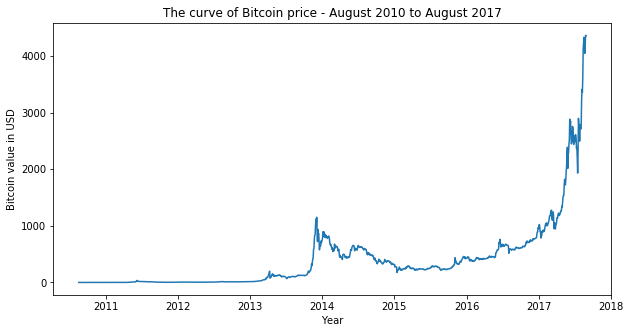

In [3]:
import matplotlib.pylab as plt
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(data,label='Actual Bitcoin Price')
ax.set(title='The curve of Bitcoin price - August 2010 to August 2017',\
         xlabel='Year', ylabel='Bitcoin value in USD')
plt.show()

A function for the dickey fuller test, to make sure we have isolated the signal from the noise, must be defined as well because it will be used on both models.

In [4]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52,center=False).mean() 
    rolstd = timeseries.rolling(window=52,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries,regression = 'ct', autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    #print dfoutput
    return dfoutput

/Users/main/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Now I examine the results of the dickey fuller test on the untransformed data, to see what happens

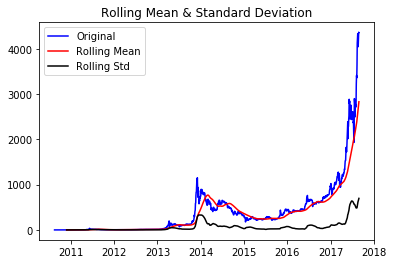

Results of Dickey-Fuller Test:


Test Statistic                    4.845046
p-value                           1.000000
#Lags Used                       23.000000
Number of Observations Used    1260.000000
Critical Value (5%)              -3.413980
Critical Value (1%)              -3.965973
Critical Value (10%)             -3.129105
dtype: float64

In [5]:
test_stationarity(data)

Telling by the test statistic relative to the critical values and the p value, we see there is a 100% chance that we'd obtain that test statistic granted the null hypothesis is true, for which the null hypothesis being that the time series is non stationary.

What we want is to convert the time series to be stationary - this means that we have separated the signal from the noise, i.e. we've found the trend in the data and only need to deal with the noise.

To find the data to be stationary, we convert it's structure to be logarithmic in form, and we give it a shift.

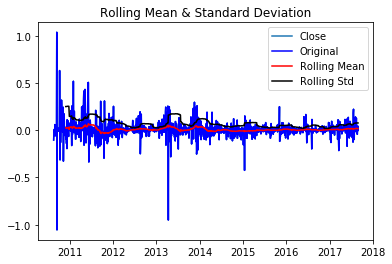

Results of Dickey-Fuller Test:


Test Statistic                -6.949747e+00
p-value                        1.835300e-08
#Lags Used                     1.500000e+01
Number of Observations Used    1.267000e+03
Critical Value (5%)           -3.413961e+00
Critical Value (1%)           -3.965933e+00
Critical Value (10%)          -3.129093e+00
dtype: float64

In [6]:
import numpy as np
bits_log = np.log(data)
bits_log_shift = bits_log - bits_log.shift()
bits_log_shift.dropna(inplace=True)
plt.plot(bits_log_shift)
test_stationarity(bits_log_shift)

Because the test statistic is less than the critical value, and the probability of obtaining that test statistic by chance is *almost* zero, we can reject the null hypothesis and conclude that in this form the time series is stationary. To be stationary, the data is now in this form:

<img src="form.png"> 

Which implies:

<img src="text.png"> 

So essentially since the trend has been removed, both the ARIMA and neural net models will be predicting the noise, and the aformentioned for loops will be adding the noise to the trend. It's fair to speculate that both models will produce similar results due to this technique since the noise fluctuations are small on a day to day basis.

PART 1: THE ARIMA MODEL

Using the transformation above, we must examine both the correlation and autocorrelation of the time series.
ARIMA models have three parameters: (p,d,q) which are the partial auto correlation, difference, and autocoreelation respectively.

The value of d is determined by the shift - d=1 in this case because we had to shift the data one unit back (see graphic above).

To find the values of p and q, we must examine the plots of the partial auto correlation and the auto correlation.

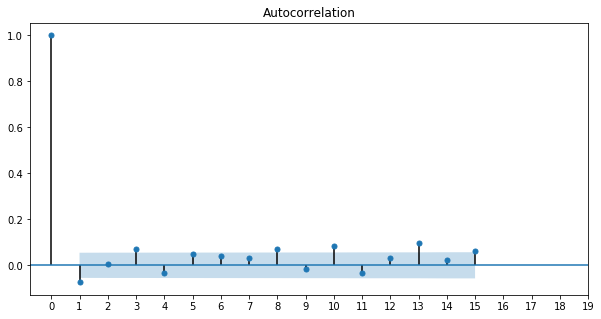

In [10]:
from statsmodels.graphics.tsaplots import plot_acf
fig, ax = plt.subplots(figsize=(10,5))
plot_acf(bits_log_shift.values, lags=15, ax=ax)
plt.xticks(np.arange(0, 20, 1))
plt.show()

This means that q = 1, since we take the first value small value.

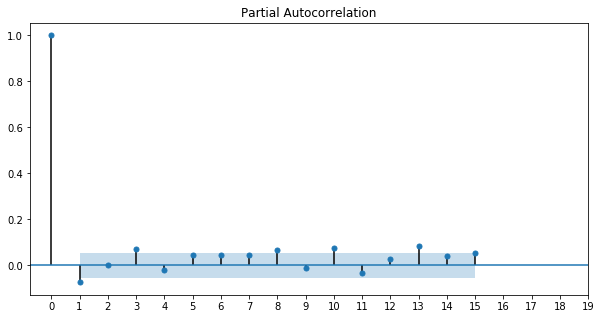

In [12]:
from statsmodels.graphics.tsaplots import plot_pacf
fig, ax = plt.subplots(figsize=(10,5))
plot_pacf(bits_log_shift.values, lags=15, ax=ax)
plt.xticks(np.arange(0, 20, 1.0))
plt.show()

Again, the elbow of the curve drops off at 1, so the partial auto correlation p = 1.
We use the ARIMA parameters of (1,1,1) for (p,d,q).

Next, we examine the ARIMA model of the noise and plot it in comparison to the transformed data.

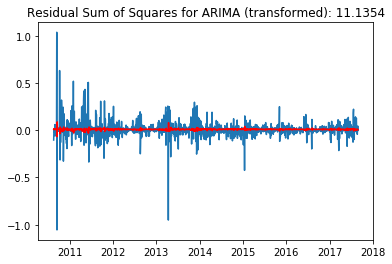

In [8]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(bits_log, order=(1, 1, 1))  
model_fit = model.fit(disp=-1)  
plt.plot(bits_log_shift)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('Residual Sum of Squares for ARIMA (transformed): %.4f'% sum((model_fit.fittedvalues-bits_log_shift)**2))
plt.show()

Now, we transform the ARIMA model to fit into the trend of the data and compare it with the curve.

Root mean square error: 416.9676


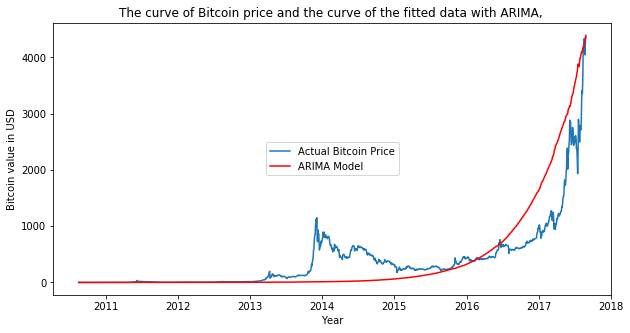

In [9]:
fittedvalues = pd.Series(model_fit.fittedvalues, copy=True)
fitcumsum = fittedvalues.cumsum()
predictions_ARIMA_log = pd.Series(bits_log.iloc[0], index=bits_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(fitcumsum,fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)

fig, ax = plt.subplots(figsize=(10,5))

plt.plot(data,label='Actual Bitcoin Price')
plt.plot(predictions_ARIMA,color = 'red',label='ARIMA Model')
ax.set(title='The curve of Bitcoin price and the curve of the fitted data with ARIMA, ',\
         xlabel='Year', ylabel='Bitcoin value in USD')
print ('Root mean square error: %.4f'% np.sqrt(sum((predictions_ARIMA-data)**2)/len(data)))
legend = ax.legend(loc='center')
plt.show()

Finally, we look at a more specific measure of model accuracy and use the ARIMA model to predict the prices for the last two weeks of August, 2017.

A for loop is defined for the length of the test set. On each point in the loop, the model is redefined, adding an element to the 'history' set for which the model is formed upon. At at i = 0 for the loop, the model is formed based on the history set (which is identical to the train set), and then a prediction is made for the next day. That prediction is appended to the predicted_values list (to be plotted) and the the first element of the test set is appeneded to the history set.

At i=1 the model is redefined so that its now based on the updated version of the history set, that now includes the first element of the test set. Then we again the model predicts the next day and appends this to the predicted_values list to be plotted. And as the loop goes on it goes through the length of the test set

In [10]:
from sklearn.metrics import mean_squared_error
train = bits_log[:-7]
test = bits_log[-7:]
history = [x for x in train]

train.dropna(inplace=True)
test.dropna(inplace=True)
predicted_values = []
tested = []

for i in range(len(test)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit(disp=0)
    forecast = model_fit.forecast(steps=1)
    yhat = float(model_fit.forecast(steps=1)[0])
    predicted_values.append(yhat)
    tested_values = test[i]
    tested.append(tested_values)
    history.append(tested_values)
    

error_ARIMA = np.sqrt(mean_squared_error(np.exp(test), np.exp(predicted_values)))

predictions_series = pd.Series(predicted_values, index = test.index)

/Users/main/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [11]:
d = list(data[-7:])
pred_ARIMA = pd.DataFrame(np.exp(predicted_values), d)
#pred = pred.set_index(data[-7:].index)
pred_ARIMA = pred_ARIMA.reset_index()
pred_ARIMA.columns = ['Actual Price','Predicted with ARIMA']
pred_ARIMA = pred_ARIMA.set_index(data[-7:].index)
pred_ARIMA

,Actual Price,Predicted with ARIMA
Date,,
2017-08-15,4217.028329,4124.313824
2017-08-17,4328.725717,4249.310181
2017-08-19,4222.662214,4360.400503
2017-08-21,4043.722000,4269.661198
2017-08-23,4174.950000,4094.086983
2017-08-25,4363.054450,4203.364882
2017-08-27,4354.308333,4389.028593


In [68]:
print('Root Mean Squared Error with ARIMA: %.6f' % error_ARIMA)

Root Mean Squared Error with ARIMA: 129.927588


Plotting this for visual examination;

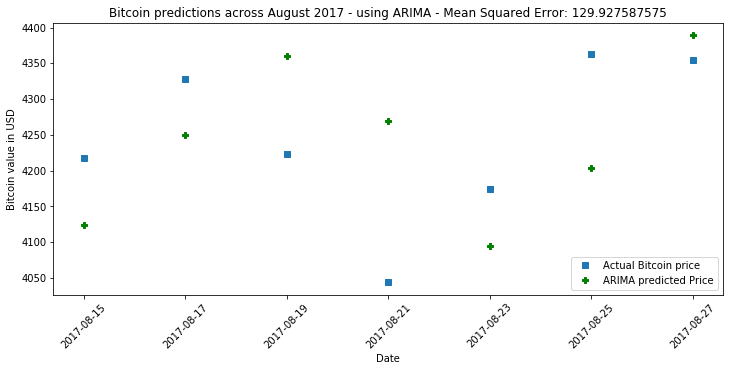

In [30]:
fig, ax = plt.subplots(figsize=(12,5))
ax.set(title='Bitcoin predictions across August 2017 - using ARIMA - Mean Squared Error: '+str(error_ARIMA), \
       xlabel='Date', ylabel='Bitcoin value in USD')
ax.plot(data[-7:], 's', label='Actual Bitcoin price')
ax.plot(np.exp(predictions_series), 'gP', label='ARIMA predicted Price')
legend = ax.legend(loc='lower right')
plt.xticks(rotation=45)
plt.show()

PART 2: Neural Net Reucrssion

In this part, I essentially try to do the same exact thing using Neural nets recurssion modelling, and examine the results. As mentioned above, it could be speculated that the answers will be nearly identical.

To do so, we must again have data in stationary format so we have separated the signal from the noise. The signal will be the same as before, so what the neural network is modelling is the noise fluctuations. Much of the work done above can be replicated.

Neural nets recurssion is a form of supervised learning, so we must transform the data once more to form an array that presents each price entry, and also a column with the preeceeding price entry.

In [14]:
from pandas import DataFrame
from pandas import concat
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

X = bits_log_shift.values
supervised = timeseries_to_supervised(X,1)
supervised_values = supervised.values

Now we split this into a train and test set like we did above.

In [15]:
train, test = supervised_values[0:-7], supervised_values[-7:]

To work with neural nets, the data must be on the same scale as the activation function. So we create another function that transforms the data to meet that scale.

In [16]:
from sklearn.preprocessing import MinMaxScaler
def scale(train, test):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    train = train.reshape(train.shape[0],train.shape[1])
    train_scaled = scaler.transform(train)
    test = test.reshape(test.shape[0],test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

scaler, train_scaled, test_scaled = scale(train, test)

Now the model is fitted.

In [17]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model


lstm_model = fit_lstm(train_scaled,1,3,4)
train_reshaped = train_scaled[:,0].reshape(len(train_scaled),1,1)

Using TensorFlow backend.


To use the model to make forecasts, we must inverse transform the data.

In [18]:
import numpy as np

def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return np.exp(yhat)*history[-interval]


Now we can make predictions.

In [19]:
predictions = []
for i in range(len(test_scaled)):
    #Make one step forecast
    X, y = test_scaled[i,0:-1], test_scaled[i,-1]
    yhat = forecast_lstm(lstm_model,1,X)
    #invert scaling
    yhat = invert_scale(scaler, X, yhat)
    #invert differencing
    yhat = inverse_difference(data, yhat, len(test_scaled)+1-i)
    #store forecast
    predictions.append(yhat)
    expected = data[len(train)+i]

In [28]:
d = list(data[-7:])
pred_neural = pd.DataFrame(predictions, d)
#pred = pred.set_index(data[-7:].index)
pred_neural = pred_neural.reset_index()
pred_neural.columns = ['Actual Price','Predicted with Neural Nets']
pred_neural = pred_neural.set_index(data[-7:].index)
pred_neural.index.name = None
pred_neural

,Actual Price,Predicted with Neural Nets
2017-08-15,4217.028329,4131.511123
2017-08-17,4328.725717,4237.543363
2017-08-19,4222.662214,4359.553868
2017-08-21,4043.722000,4260.638273
2017-08-23,4174.950000,4086.054588
2017-08-25,4363.054450,4221.376319
2017-08-27,4354.308333,4413.770379


In [21]:
rmse_neural_net = np.sqrt(mean_squared_error(data[-7:], predictions))
print ('Test RMSE with Neural Nets: %.3f' % rmse_neural_net)

Test RMSE with Neural Nets: 127.015


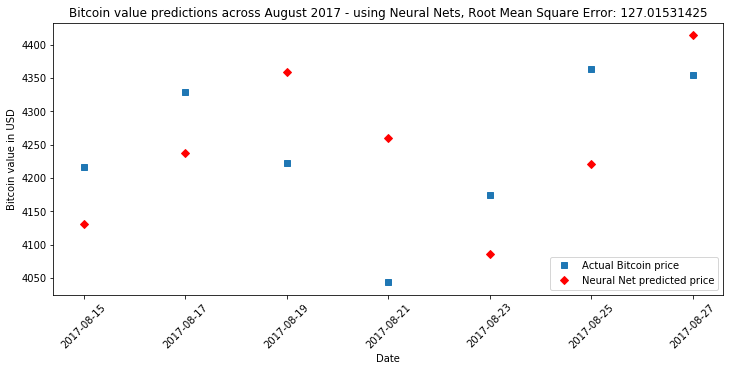

In [24]:
pred = pd.Series(predictions, index = data[-7:].index)
from matplotlib import pyplot as plt
# line plot of observed vs predicted

fig, ax = plt.subplots(figsize=(12,5))
ax.set(title='Bitcoin value predictions across August 2017 - using Neural Nets, Root Mean Square Error: '+str(rmse_neural_net), \
       xlabel='Date', ylabel='Bitcoin value in USD', label=str(rmse_neural_net))
ax.plot(data[-7:], 's', label='Actual Bitcoin price')
ax.plot(pred, 'rD', label='Neural Net predicted price')
legend = ax.legend(loc='lower right')
plt.xticks(rotation=45)
plt.show()

Comparing the error metrics of neural net recusion and ARIMA, the difference is

In [25]:
print "Error difference between ARIMA model and Neural Nets: " + str(rmse_neural_net - error_ARIMA)

Error difference between ARIMA model and Neural Nets: -2.91227332564


In [29]:
comparison = pd.merge(pred_ARIMA,pred_neural)
comparison = comparison.set_index(data[-7:].index)
comparison.index.name = None
comparison

,Actual Price,Predicted with ARIMA,Predicted with Neural Nets
2017-08-15,4217.028329,4124.313824,4131.511123
2017-08-17,4328.725717,4249.310181,4237.543363
2017-08-19,4222.662214,4360.400503,4359.553868
2017-08-21,4043.722000,4269.661198,4260.638273
2017-08-23,4174.950000,4094.086983,4086.054588
2017-08-25,4363.054450,4203.364882,4221.376319
2017-08-27,4354.308333,4389.028593,4413.770379


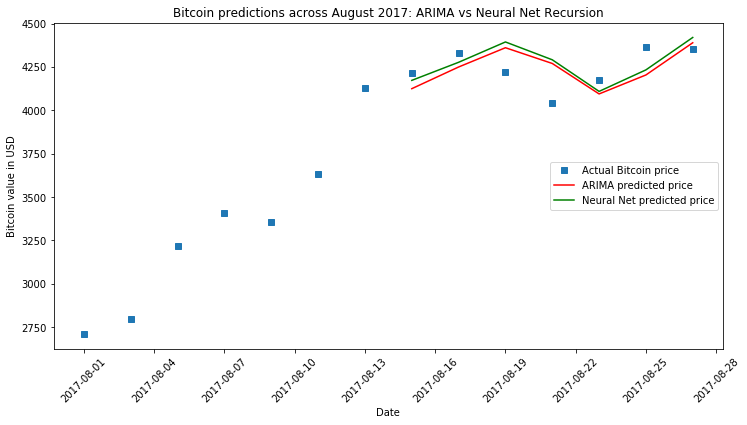

In [144]:
fig, ax = plt.subplots(figsize=(12,6))
ax.set(title='Bitcoin predictions across August 2017: ARIMA vs Neural Net Recursion', xlabel='Date', ylabel='Bitcoin value in USD')
ax.plot(data[-14:], 's', label='Actual Bitcoin price')
ax.plot(np.exp(predictions_series), 'r', label='ARIMA predicted price')
ax.plot(pred, 'g', label='Neural Net predicted price')
legend = ax.legend(loc='center right')
plt.xticks(rotation=45)
plt.savefig("August2017_both_models.png")
plt.show()